Étape 1 : Le Script d'Ingestion (Téléchargement)

In [1]:
import os
import requests

# 1. Configuration
# On crée un dossier pour stocker nos données brutes
output_dir = "data/nyc_taxi_raw"
os.makedirs(output_dir, exist_ok=True)

years = ["2014", "2015", "2016", "2017", "2018", "2019", "2020", "2021", "2022", "2023", "2024"]
months = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]

print(f"--- Démarrage du téléchargement vers {output_dir} ---")

# 2. Boucle de téléchargement
for year in years:
    for month in months:
        filename = f"yellow_tripdata_{year}-{month}.parquet"
        # URL officielle du NYC TLC
        url = f"https://d37ci6vzurychx.cloudfront.net/trip-data/{filename}"
        save_path = os.path.join(output_dir, filename)
    
        if not os.path.exists(save_path):
            print(f"Téléchargement de {filename}...", end=" ")
            try:
                r = requests.get(url)
                with open(save_path, 'wb') as f:
                    f.write(r.content)
                print("✅ OK")
            except Exception as e:
                print(f"❌ Erreur : {e}")
        else:
            print(f"ℹ️ {filename} déjà présent.")

print("--- Téléchargement terminé ! ---")

--- Démarrage du téléchargement vers data/nyc_taxi_raw ---
ℹ️ yellow_tripdata_2014-01.parquet déjà présent.
ℹ️ yellow_tripdata_2014-02.parquet déjà présent.
ℹ️ yellow_tripdata_2014-03.parquet déjà présent.
ℹ️ yellow_tripdata_2014-04.parquet déjà présent.
ℹ️ yellow_tripdata_2014-05.parquet déjà présent.
ℹ️ yellow_tripdata_2014-06.parquet déjà présent.
ℹ️ yellow_tripdata_2014-07.parquet déjà présent.
ℹ️ yellow_tripdata_2014-08.parquet déjà présent.
ℹ️ yellow_tripdata_2014-09.parquet déjà présent.
ℹ️ yellow_tripdata_2014-10.parquet déjà présent.
ℹ️ yellow_tripdata_2014-11.parquet déjà présent.
ℹ️ yellow_tripdata_2014-12.parquet déjà présent.
ℹ️ yellow_tripdata_2015-01.parquet déjà présent.
ℹ️ yellow_tripdata_2015-02.parquet déjà présent.
ℹ️ yellow_tripdata_2015-03.parquet déjà présent.
ℹ️ yellow_tripdata_2015-04.parquet déjà présent.
ℹ️ yellow_tripdata_2015-05.parquet déjà présent.
ℹ️ yellow_tripdata_2015-06.parquet déjà présent.
ℹ️ yellow_tripdata_2015-07.parquet déjà présent.
ℹ️ yellow_

Étape 2 : Premier contact avec Spark

Maintenant que les fichiers sont sur le disque du Mac Pro, demandons à Spark de les charger tous d'un coup. C'est la force de Spark : on peut lui donner un dossier entier.

In [64]:
import os
from functools import reduce
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import col, avg, count, desc

# 1. Démarrage de la session (avec allocation de ressources)
spark = SparkSession.builder \
    .appName("ProjetTaxiNYC") \
    .master("local[*]") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

# On nettoie la mémoire de Spark pour éviter les vieux schémas fantômes
spark.catalog.clearCache()
spark.conf.set("spark.sql.parquet.enableVectorizedReader", "false")
spark.conf.set("spark.sql.caseSensitive", "false")

# --- 2. LISTING DES FICHIERS ---
dossier_data = "data/nyc_taxi_raw/"
tous_fichiers = [f for f in os.listdir(dossier_data) if f.endswith(".parquet")]

# On cible les années "Modernes" (2017 à 2024)
annees_cibles = ["2017", "2018", "2019", "2020", "2021", "2022", "2023", "2024"]
paths = [os.path.join(dossier_data, f) for f in tous_fichiers if any(annee in f for annee in annees_cibles)]
paths.sort()

print(f"Traitement de {len(paths)} fichiers (Conservation de toutes les colonnes)...")

# --- 3. FONCTION DE NORMALISATION UNIVERSELLE ---
def load_and_normalize_full(path):
    # A. Lecture brute (Spark découvre le schéma de CE fichier)
    df_temp = spark.read.parquet(path)
    
    # B. Liste des colonnes numériques à risque (IDs et Montants)
    # On va forcer toutes ces colonnes en DOUBLE si elles existent dans le fichier.
    # Cela règle le conflit "Int vs Double" et "Dictionnaire vs Double".
    cols_a_convertir = [
        "VendorID", "passenger_count", "trip_distance", "RatecodeID", 
        "PULocationID", "DOLocationID", "payment_type", "fare_amount", 
        "extra", "mta_tax", "tip_amount", "tolls_amount", 
        "improvement_surcharge", "total_amount", "congestion_surcharge", "airport_fee"
    ]
    
    for c in cols_a_convertir:
        if c in df_temp.columns:
            # On convertit en Double pour être sûr (1 devient 1.0)
            df_temp = df_temp.withColumn(c, col(c).cast(DoubleType()))
            
    return df_temp

# --- 4. BOUCLE DE LECTURE ---
dfs = []
for p in paths:
    try:
        dfs.append(load_and_normalize_full(p))
    except Exception as e:
        print(f"Erreur sur {p}: {e}")

# --- 5. FUSION INTELLIGENTE ---
if dfs:
    print("Fusion des DataFrames (avec gestion des colonnes manquantes)...")
    
    # L'option allowMissingColumns=True est MAGIQUE ici.
    # Si un fichier de 2017 n'a pas "airport_fee", Spark remplira avec null au lieu de planter.
    def union_permissive(df1, df2):
        return df1.unionByName(df2, allowMissingColumns=True)
    
    df_final = reduce(union_permissive, dfs)
    
    # --- 6. CACHE & NETTOYAGE ---
    # On remet les IDs en Entiers maintenant que tout est unifié, pour que ce soit propre
    # (Les nulls resteront nulls)
    df_final = df_final \
        .withColumn("PULocationID", col("PULocationID").cast("int")) \
        .withColumn("DOLocationID", col("DOLocationID").cast("int")) \
        .withColumn("VendorID", col("VendorID").cast("int")) \
        .withColumn("payment_type", col("payment_type").cast("int"))

    # Filtre de base
    df = df_final.filter(
        (col("trip_distance") > 0) & 
        (col("total_amount") > 0)
    )

    print(f"--- TERMINE ---")
    print(f"Total courses : {df.count():,}")
    print("Aperçu du schéma complet unifié :")
    df.printSchema()

else:
    print("Aucun DataFrame à fusionner.")


# La preuve du volume
count = df.count()
print(f"Nombre total de courses chargées : {count:,}".replace(",", " "))

# 4. Regardons la structure
df.printSchema()



Traitement de 94 fichiers (Conservation de toutes les colonnes)...
Fusion des DataFrames (avec gestion des colonnes manquantes)...
--- TERMINE ---


Total courses : 452,125,087
Aperçu du schéma complet unifié :
root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: double (nullable = true)



[Stage 302:==================================================>(1509 + 3) / 1512]

Nombre total de courses chargées : 452 125 087
root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: double (nullable = true)



Ce que vous devriez voir : Vous devriez avoir environ 8 à 10 millions de lignes. Regardez le schéma (printSchema). Voici les colonnes clés à comprendre :

tpep_pickup_datetime : Date et heure de prise en charge.

trip_distance : Distance en miles.

PULocationID / DOLocationID : Zones de départ (PickUp) et d'arrivée (DropOff). Ce sont des ID numériques (ex: 132 = Aéroport JFK).

total_amount : Le prix total payé.

Étape 3 : Votre première analyse "Big Data"

Faisons une requête pour voir si les données sont cohérentes. Cherchons les courses les plus longues (en distance).

In [65]:
# On sélectionne quelques colonnes et on trie par distance décroissante
df.select("tpep_pickup_datetime", "trip_distance", "total_amount") \
  .orderBy(desc("trip_distance")) \
  .show(10)

+--------------------+-------------+------------+
|tpep_pickup_datetime|trip_distance|total_amount|
+--------------------+-------------+------------+
| 2024-11-28 19:28:00|    398608.62|       26.04|
| 2022-10-28 05:19:00|    389678.46|       18.83|
| 2024-10-16 17:24:00|    366343.04|       26.06|
| 2022-05-15 18:45:00|    357192.65|       20.13|
| 2021-11-16 12:55:00|    351613.36|       19.88|
| 2020-12-10 08:39:00|    350914.89|       57.35|
| 2020-12-09 08:57:00|    350814.14|       63.42|
| 2020-12-09 08:22:00|     350793.6|       34.09|
| 2020-12-08 10:59:00|    350722.34|        60.0|
| 2020-12-08 09:16:00|    350696.98|        21.2|
+--------------------+-------------+------------+
only showing top 10 rows


Étape 4 : Visualisation Géographique (Le défi)

Les colonnes PULocationID sont des numéros. Pour savoir que "132" est l'aéroport JFK et "237" est Central Park, nous avons besoin d'un fichier de correspondance (une table de dimension).

Téléchargeons ce petit fichier CSV de référence (Lookup Table) pour pouvoir enrichir nos données plus tard.

In [66]:
# Téléchargement du fichier des zones
url_zones = "https://d37ci6vzurychx.cloudfront.net/misc/taxi+_zone_lookup.csv"
r = requests.get(url_zones)
with open("data/taxi_zones.csv", 'wb') as f:
    f.write(r.content)

print("Fichier des zones téléchargé.")

# Chargement dans Spark pour vérifier
df_zones = spark.read.option("header", "true").csv("data/taxi_zones.csv")
df_zones.show(5)

Fichier des zones téléchargé.
+----------+-------------+--------------------+------------+
|LocationID|      Borough|                Zone|service_zone|
+----------+-------------+--------------------+------------+
|         1|          EWR|      Newark Airport|         EWR|
|         2|       Queens|         Jamaica Bay|   Boro Zone|
|         3|        Bronx|Allerton/Pelham G...|   Boro Zone|
|         4|    Manhattan|       Alphabet City| Yellow Zone|
|         5|Staten Island|       Arden Heights|   Boro Zone|
+----------+-------------+--------------------+------------+
only showing top 5 rows


Le Code : Qui sont les clients les plus généreux ?

In [67]:
from pyspark.sql.functions import col, avg, count, desc

# --- ÉTAPE 1 : LE NETTOYAGE (Cleaning) ---
# On enlève le "bruit" :
# - Distance <= 0 (Bug GPS ou annulation)
# - Total Amount <= 0 (Erreur ou course gratuite)
# - Passagers = 0 (Possiblement livraison de colis, mais on veut étudier les humains)
df_clean = df.filter(
    (col("trip_distance") > 0) & 
    (col("total_amount") > 0) & 
    (col("passenger_count") > 0)
)

print(f"Lignes après nettoyage : {df_clean.count():,} (On a perdu quelques milliers de lignes sales)")

# --- ÉTAPE 2 : LA JOINTURE (Enrichissement) ---
# On veut coller le nom du quartier (Zone) en face de l'ID de départ (PULocationID)
# Le fichier CSV des zones a une colonne "LocationID"
# Le fichier Parquet des taxis a une colonne "PULocationID"

# On s'assure que les types sont compatibles (entiers)
# Note: df_zones a été chargé depuis un CSV, Spark peut l'avoir lu en string.
df_zones = df_zones.withColumn("LocationID", col("LocationID").cast("int"))

df_enriched = df_clean.join(
    df_zones, 
    df_clean.PULocationID == df_zones.LocationID, 
    "left" # On garde la course même si on ne trouve pas la zone (sécurité)
)

# --- ÉTAPE 3 : L'AGRÉGATION (L'Analyse) ---
# Question : Moyenne des pourboires par Quartier
# PIÈGE STATISTIQUE : Si on ne filtre pas, un quartier avec 1 seule course et 50$ de pourboire
# va sembler être le meilleur. Il faut définir un "seuil de pertinence".

seuil_courses = 100 # Il faut au moins 100 courses pour que le quartier soit jugé

df_resultat = df_enriched.groupBy("Zone") \
    .agg(
        avg("tip_amount").alias("Moyenne_Pourboire"),
        count("*").alias("Nombre_Courses")
    ) \
    .filter(col("Nombre_Courses") >= seuil_courses) \
    .orderBy(desc("Moyenne_Pourboire"))

# --- ÉTAPE 4 : AFFICHAGE ---
print("--- TOP 20 des Quartiers les plus généreux (Q1 2024) ---")
df_resultat.show(20, truncate=False)

Lignes après nettoyage : 438,088,370 (On a perdu quelques milliers de lignes sales)
--- TOP 20 des Quartiers les plus généreux (Q1 2024) ---


[Stage 312:==================================================>(1510 + 2) / 1512]

+--------------------------------+-----------------+--------------+
|Zone                            |Moyenne_Pourboire|Nombre_Courses|
+--------------------------------+-----------------+--------------+
|Newark Airport                  |10.96598214285714|12992         |
|Flushing Meadows-Corona Park    |7.713458097275961|90197         |
|Baisley Park                    |7.315307733072436|122655        |
|Outside of NYC                  |7.107785080907773|99805         |
|JFK Airport                     |6.948146720670142|14507322      |
|East Elmhurst                   |6.898659580075844|595679        |
|Randalls Island                 |6.569296995457767|23997         |
|South Jamaica                   |6.414121846232522|46928         |
|South Ozone Park                |6.384852117430256|54807         |
|LaGuardia Airport               |6.376868279696689|12120546      |
|Springfield Gardens South       |6.139145043814724|35148         |
|Jamaica Bay                     |5.772975206611

Le Défi Visuel (Bonus)

Ce tableau est bien, mais un graphique est mieux. Puisque le résultat (df_resultat) est agrégé (seulement quelques centaines de zones), nous pouvons le convertir en Pandas sans danger pour faire un Bar Chart.

Ajoutez cette cellule pour visualiser le Top 10 :

/tmp/ipykernel_37842/2559662531.py:8: FutureWarning:                            

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Moyenne_Pourboire', y='Zone', data=pdf, palette='magma')


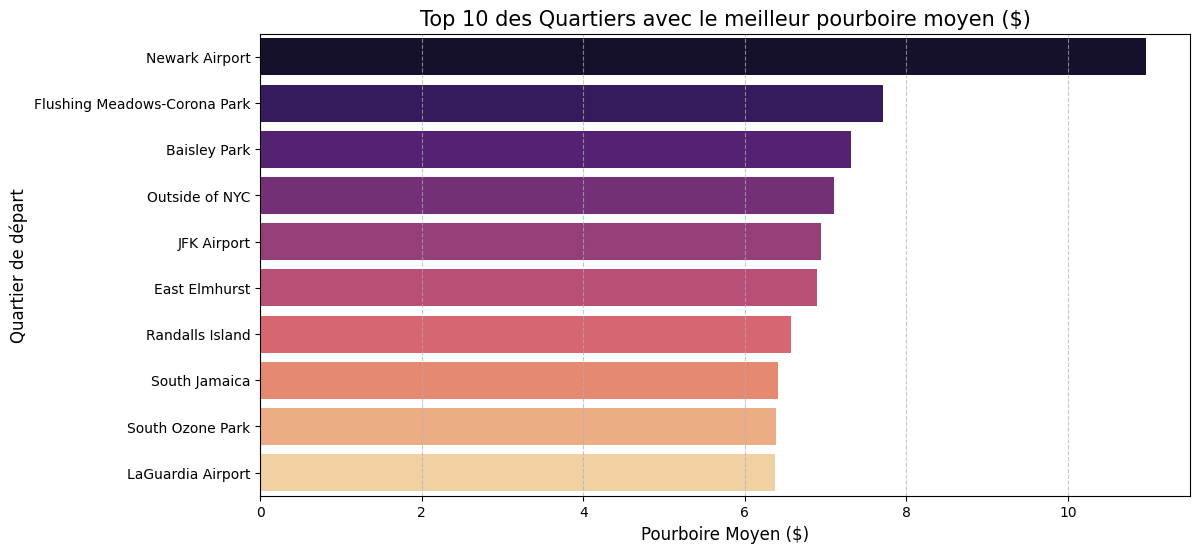

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns

# Conversion vers Pandas (très rapide car peu de lignes)
pdf = df_resultat.limit(10).toPandas()

plt.figure(figsize=(12, 6))
sns.barplot(x='Moyenne_Pourboire', y='Zone', data=pdf, palette='magma')

plt.title('Top 10 des Quartiers avec le meilleur pourboire moyen ($)', fontsize=15)
plt.xlabel('Pourboire Moyen ($)', fontsize=12)
plt.ylabel('Quartier de départ', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

Calculons le Pourcentage de Pourboire (Tip Percentage). C'est le vrai indicateur de la générosité.

In [69]:
from pyspark.sql.functions import round, col, when

# 1. NETTOYAGE PRÉALABLE (Sécurité anti-crash)
# On ne garde que les courses où le prix (hors pourboire) est strictement positif.
# Cela élimine mathématiquement le risque de division par zéro.
df_safe = df_enriched.filter(
    (col("total_amount") - col("tip_amount")) > 0
)

# 2. CALCUL DU POURCENTAGE
df_percent = df_safe.withColumn(
    "Tip_Pct", 
    round((col("tip_amount") / (col("total_amount") - col("tip_amount"))) * 100, 2)
)

# 3. AGRÉGATION
df_generosite = df_percent.groupBy("Zone") \
    .agg(
        avg("Tip_Pct").alias("Moyenne_Pct_Pourboire"),
        avg("total_amount").alias("Prix_Moyen_Course"),
        count("*").alias("Nb_Courses")
    ) \
    .filter(col("Nb_Courses") > 100) \
    .orderBy(desc("Moyenne_Pct_Pourboire"))

print("--- Les Quartiers les plus GÉNÉREUX (en %) ---")
df_generosite.show(20, truncate=False)

--- Les Quartiers les plus GÉNÉREUX (en %) ---


25/12/08 13:36:51 WARN DAGScheduler: Broadcasting large task binary with size 1020.0 KiB
[Stage 320:==================================================>(1509 + 3) / 1512]

+--------------------------------+---------------------+------------------+----------+
|Zone                            |Moyenne_Pct_Pourboire|Prix_Moyen_Course |Nb_Courses|
+--------------------------------+---------------------+------------------+----------+
|Broad Channel                   |159.89548387096772   |36.882            |155       |
|Outside of NYC                  |116.13788617804701   |68.43653784880588 |99805     |
|Newark Airport                  |81.74866841133002    |92.75454510467962 |12992     |
|Mariners Harbor                 |44.929748427672955   |51.006729559748415|795       |
|Pelham Bay Park                 |37.079378980891725   |51.28359872611462 |628       |
|Marine Park/Floyd Bennett Field |36.334183535762456   |53.559172289698594|2223      |
|Willets Point                   |33.71640791476408    |56.19329528158291 |1314      |
|Bronx Park                      |33.50427637721754    |34.43944444444444 |2142      |
|Whitestone                      |28.310712

Étape 1 : Préparation des données (Feature Engineering)

In [70]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# 1. SÉLECTION ET NETTOYAGE
# On garde juste ce qui nous intéresse pour ce premier modèle simple.
# On filtre les valeurs extrêmes pour aider le modèle (ex: courses > 100 miles ou prix > 200$)
df_ml = df_clean.select("trip_distance", "total_amount") \
    .filter((col("trip_distance") < 100) & (col("total_amount") < 200))

# 2. VECTORISATION (La méthode Spark)
# On transforme la colonne "trip_distance" en un VECTEUR appelé "features"
assembler = VectorAssembler(
    inputCols=["trip_distance"], # Ici on pourrait mettre ["trip_distance", "passenger_count", etc.]
    outputCol="features"
)

# On applique la transformation
df_vectorized = assembler.transform(df_ml)

# Regardons à quoi ça ressemble pour Spark
print("--- Données prêtes pour le ML ---")
df_vectorized.select("features", "total_amount").show(5)

--- Données prêtes pour le ML ---
+--------+------------+
|features|total_amount|
+--------+------------+
|   [1.2]|         7.8|
|   [0.7]|         6.3|
|   [0.8]|         6.8|
|   [1.1]|         7.3|
|   [3.0]|        12.3|
+--------+------------+
only showing top 5 rows


Ce que vous voyez : Une colonne features qui contient des [1.2], [0.5]. C'est le format que le moteur mathématique attend.

Étape 2 : Entraînement (Training

Comme tout bon Data Scientist, nous devons séparer nos données en deux :

Training Set (80%) : Pour que le modèle apprenne (les "devoirs").
Test Set (20%) : Pour vérifier s'il a bien appris (l'"examen").

In [71]:
# 1. SPLIT (Séparation)
train_data, test_data = df_vectorized.randomSplit([0.8, 0.2], seed=42)

print(f"Données d'entraînement : {train_data.count()} lignes")
print(f"Données de test : {test_data.count()} lignes")

# 2. DÉFINITION DU MODÈLE
# On lui dit : "Essaie de prédire 'total_amount' en utilisant 'features'"
lr = LinearRegression(featuresCol="features", labelCol="total_amount")

print("--- Démarrage de l'entraînement sur le Mac Pro... ---")

# 3. ENTRAÎNEMENT (FIT)
# C'est ici que vos ventilateurs vont tourner !
lr_model = lr.fit(train_data)

print("--- Entraînement terminé ! ---")

Données d'entraînement : 350399473 lignes


Données de test : 87584945 lignes
--- Démarrage de l'entraînement sur le Mac Pro... ---


25/12/08 13:43:16 WARN Instrumentation: [f300a3f0] regParam is zero, which might cause numerical instability and overfitting.
[Stage 334:==================================================>(1511 + 1) / 1512]

--- Entraînement terminé ! ---


Étape 3 : Évaluation et Prédictions

Le modèle est entraîné. Il a trouvé une équation mathématique du type Prix = A * Distance + B. Voyons s'il est bon.

In [73]:
# 1. LES COEFFICIENTS
# Un modèle linéaire, c'est juste une droite : y = ax + b
pente = lr_model.coefficients[0]
depart = lr_model.intercept

print(f"L'équation trouvée par l'IA est : Prix = {pente:.2f} * Distance + {depart:.2f}$")
print("Cela signifie que le compteur démarre à {:.2f}$ et ajoute {:.2f}$ par mile.".format(depart, pente))


# 2. L'EXAMEN (Prédictions sur le Test Set)
predictions = lr_model.transform(test_data)

print("\n--- Comparaison Réalité vs Prédiction ---")
predictions.select("trip_distance", "total_amount", "prediction").show(10)

# 3. LA NOTE FINAL (RMSE et R2)
evaluator = RegressionEvaluator(
    labelCol="total_amount", predictionCol="prediction", metricName="rmse"
)
rmse = evaluator.evaluate(predictions)

evaluator_r2 = RegressionEvaluator(
    labelCol="total_amount", predictionCol="prediction", metricName="r2"
)
r2 = evaluator_r2.evaluate(predictions)

print(f"Erreur moyenne (RMSE) : {rmse:.2f} $")
print(f"Précision du modèle (R2) : {r2:.2f} (1.0 = Parfait, 0.0 = Nul)")

L'équation trouvée par l'IA est : Prix = 3.68 * Distance + 8.11$
Cela signifie que le compteur démarre à 8.11$ et ajoute 3.68$ par mile.

--- Comparaison Réalité vs Prédiction ---


+-------------+------------+-----------------+
|trip_distance|total_amount|       prediction|
+-------------+------------+-----------------+
|         0.01|        0.31|8.147180157687094|
|         0.01|         3.3|8.147180157687094|
|         0.01|         3.3|8.147180157687094|
|         0.01|         3.3|8.147180157687094|
|         0.01|         3.3|8.147180157687094|
|         0.01|         3.3|8.147180157687094|
|         0.01|         3.3|8.147180157687094|
|         0.01|         3.3|8.147180157687094|
|         0.01|         3.3|8.147180157687094|
|         0.01|         3.3|8.147180157687094|
+-------------+------------+-----------------+
only showing top 10 rows


[Stage 348:==================================================>(1511 + 1) / 1512]

Erreur moyenne (RMSE) : 7.07 $
Précision du modèle (R2) : 0.81 (1.0 = Parfait, 0.0 = Nul)


La Preuve Visuelle (Le graphique final)

/home/laurent/mySpark/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


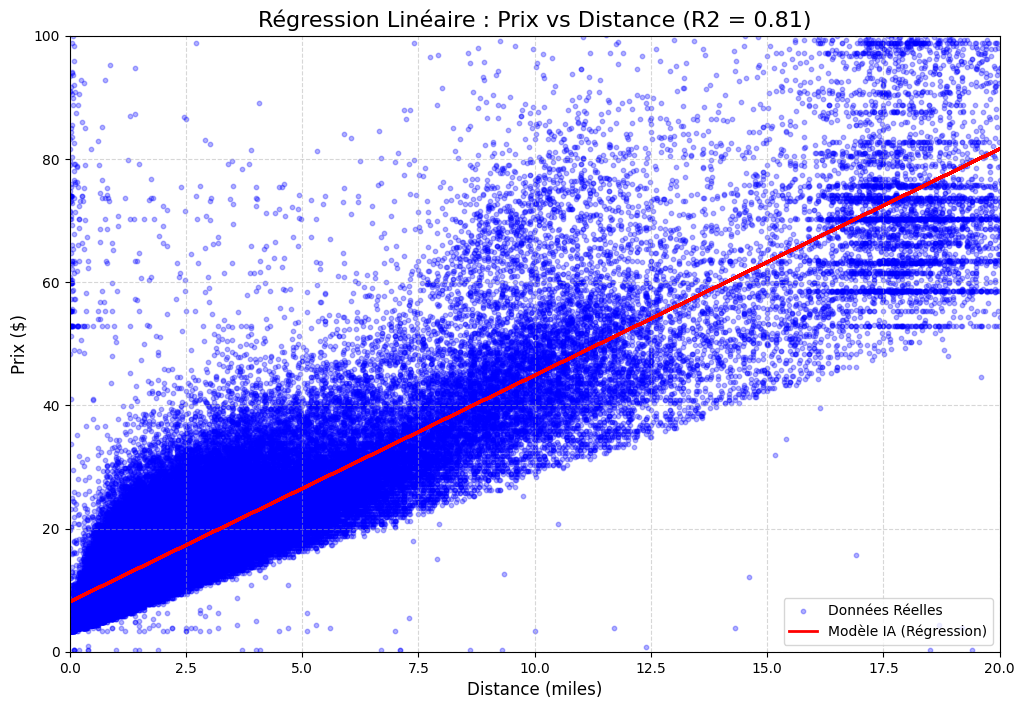

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. ÉCHANTILLONNAGE (Sampling)
# On ne prend que 0.2% des données pour le dessin (ce qui fait déjà ~20 000 points)
# "False" signifie qu'on ne remet pas la donnée dans le paquet après l'avoir tirée
pdf_viz = predictions.sample(False, 0.002, seed=42).toPandas()

# 2. LE GRAPHIQUE
plt.figure(figsize=(12, 8))

# A. Les points réels (La Réalité)
# alpha=0.3 rend les points transparents pour voir la densité (là où c'est foncé, il y a beaucoup de courses)
plt.scatter(pdf_viz['trip_distance'], pdf_viz['total_amount'], 
            alpha=0.3, color='blue', label='Données Réelles', s=10)

# B. La ligne de l'IA (La Prédiction)
plt.plot(pdf_viz['trip_distance'], pdf_viz['prediction'], 
         color='red', linewidth=2, label='Modèle IA (Régression)')

# Esthétique
plt.title(f'Régression Linéaire : Prix vs Distance (R2 = {r2:.2f})', fontsize=16)
plt.xlabel('Distance (miles)', fontsize=12)
plt.ylabel('Prix ($)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

# On limite les axes pour zoomer sur l'essentiel (0 à 20 miles)
plt.xlim(0, 20)
plt.ylim(0, 100)

plt.show()